# 02 - Statistical Analysis: State & Regional Treatment Patterns
## Trigeminal Neuralgia Treatment Patterns Analysis

**Data Source:** Epic Cosmos (cleaned)  
**Study Period:** November 28, 2022 - November 27, 2025 (3 years)  
**Total Patients:** ~293,000 with TN diagnosis (ICD-10: G50.0)  
**Target Journal:** Journal of Neurosurgery (JNS)

---

### Analysis Overview

1. **Medication Utilization Rates** - State and regional rates vs. national average
2. **Procedure Utilization Rates** - State and regional rates vs. national average  
3. **Geographic Variation** - Chi-square tests for regional differences
4. **Medication-Procedure Combinations** - Treatment pathway analysis
5. **Outlier Detection** - States significantly above/below national benchmarks

### Statistical Methods

- **Proportions**: Medication/procedure rates as % of total TN patients
- **Z-test for proportions**: Compare state/region rate to national rate
- **Chi-square test**: Test for overall differences across regions
- **Confidence intervals**: 95% CI for all rates

---


## 1. Setup and Load Data


In [38]:
# Standard imports
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot settings - JNS style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

# Project imports
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from src.config import (
    PROCESSED_DATA_DIR, TABLES_DIR, FIGURES_DIR,
    TN_CONFIG, CENSUS_REGIONS, JNS
)

print(f"Project root: {project_root}")
print(f"Data dir: {PROCESSED_DATA_DIR}")


Project root: /Users/dhirajpangal/Library/Mobile Documents/com~apple~CloudDocs/Desktop/RESEARCH/STANFORD/Cosmos/trigeminalneuralgia-cosmos
Data dir: /Users/dhirajpangal/Library/Mobile Documents/com~apple~CloudDocs/Desktop/RESEARCH/STANFORD/Cosmos/trigeminalneuralgia-cosmos/analysis/outputs/data


In [39]:
# Load cleaned data (US states + DC only, territories/international excluded)
df_meds = pd.read_csv(PROCESSED_DATA_DIR / 'state_medications_clean.csv')
df_procs = pd.read_csv(PROCESSED_DATA_DIR / 'state_procedures_clean.csv')
df_cross = pd.read_csv(PROCESSED_DATA_DIR / 'state_meds_procedures_clean.csv')

print("Loaded datasets (US states + DC only):")
print(f"  Medications: {df_meds.shape} - {df_meds['total'].sum():,} patients")
print(f"  Procedures: {df_procs.shape}")
print(f"  Cross-tab: {df_cross.shape}")
print(f"  States: {df_meds['state'].nunique()} (50 US states + DC)")
print(f"  Census regions: {df_meds['census_region'].nunique()}")

# Define column lists for analysis
MED_COLS = ['carbamazepine_oxcarbazepine', 'gabapentin', 'pregabalin', 
            'baclofen', 'lamotrigine', 'onabotulinumtoxina', 'none_of_above']

PROC_COLS = ['mvd', 'srs', 'rhizotomy', 'glycerol_rhizotomy', 'botox', 'none_of_above']

# Filter to only include columns that exist
MED_COLS = [c for c in MED_COLS if c in df_meds.columns]
PROC_COLS = [c for c in PROC_COLS if c in df_procs.columns]

# Display names for prettier output
MED_DISPLAY = {
    'carbamazepine_oxcarbazepine': 'Carbamazepine/Oxcarbazepine',
    'gabapentin': 'Gabapentin',
    'pregabalin': 'Pregabalin',
    'baclofen': 'Baclofen',
    'lamotrigine': 'Lamotrigine',
    'onabotulinumtoxina': 'OnabotulinumtoxinA',
    'none_of_above': 'No TN Medication'
}

PROC_DISPLAY = {
    'mvd': 'MVD',
    'srs': 'SRS (Radiosurgery)',
    'rhizotomy': 'Percutaneous Rhizotomy',
    'glycerol_rhizotomy': 'Glycerol Rhizotomy',
    'botox': 'Botox',
    'none_of_above': 'No Procedure'
}

print(f"\nMedication columns: {MED_COLS}")
print(f"Procedure columns: {PROC_COLS}")


Loaded datasets (US states + DC only):
  Medications: (51, 10) - 290,088 patients
  Procedures: (51, 9)
  Cross-tab: (357, 10)
  States: 51 (50 US states + DC)
  Census regions: 9

Medication columns: ['carbamazepine_oxcarbazepine', 'gabapentin', 'pregabalin', 'baclofen', 'lamotrigine', 'onabotulinumtoxina', 'none_of_above']
Procedure columns: ['mvd', 'srs', 'rhizotomy', 'glycerol_rhizotomy', 'botox', 'none_of_above']


## 2. National Baseline Rates

Calculate the national average utilization rates for medications and procedures. These serve as the reference point for all geographic comparisons.


In [40]:
# Calculate national totals
NATIONAL_TOTAL = df_meds['total'].sum()
print(f"Total TN patients nationally: {NATIONAL_TOTAL:,}")

# National medication rates
national_med_rates = {}
for col in MED_COLS:
    n = df_meds[col].sum()
    rate = n / NATIONAL_TOTAL * 100
    national_med_rates[col] = {'n': n, 'rate': rate}

# National procedure rates  
national_proc_rates = {}
for col in PROC_COLS:
    n = df_procs[col].sum()
    rate = n / NATIONAL_TOTAL * 100
    national_proc_rates[col] = {'n': n, 'rate': rate}

# Create summary tables
print("\n" + "=" * 70)
print("NATIONAL MEDICATION UTILIZATION RATES")
print("=" * 70)
med_summary = pd.DataFrame([
    {'Medication': MED_DISPLAY.get(col, col), 
     'N': national_med_rates[col]['n'],
     'Rate (%)': national_med_rates[col]['rate']}
    for col in MED_COLS
]).sort_values('Rate (%)', ascending=False)
med_summary['N'] = med_summary['N'].apply(lambda x: f"{x:,}")
print(med_summary.to_string(index=False))

print("\n" + "=" * 70)
print("NATIONAL PROCEDURE UTILIZATION RATES")
print("=" * 70)
proc_summary = pd.DataFrame([
    {'Procedure': PROC_DISPLAY.get(col, col),
     'N': national_proc_rates[col]['n'],
     'Rate (%)': national_proc_rates[col]['rate']}
    for col in PROC_COLS
]).sort_values('Rate (%)', ascending=False)
proc_summary['N'] = proc_summary['N'].apply(lambda x: f"{x:,}")
print(proc_summary.to_string(index=False))


Total TN patients nationally: 290,088

NATIONAL MEDICATION UTILIZATION RATES
                 Medication       N  Rate (%)
                 Gabapentin 148,000     51.02
Carbamazepine/Oxcarbazepine 123,851     42.69
           No TN Medication  63,719     21.97
                   Baclofen  47,736     16.46
                 Pregabalin  47,032     16.21
                Lamotrigine  19,266      6.64
         OnabotulinumtoxinA  14,972      5.16

NATIONAL PROCEDURE UTILIZATION RATES
             Procedure       N  Rate (%)
          No Procedure 279,762     96.44
                   MVD   4,033      1.39
    Glycerol Rhizotomy   2,616      0.90
                 Botox   2,069      0.71
    SRS (Radiosurgery)   1,813      0.62
Percutaneous Rhizotomy     972      0.34


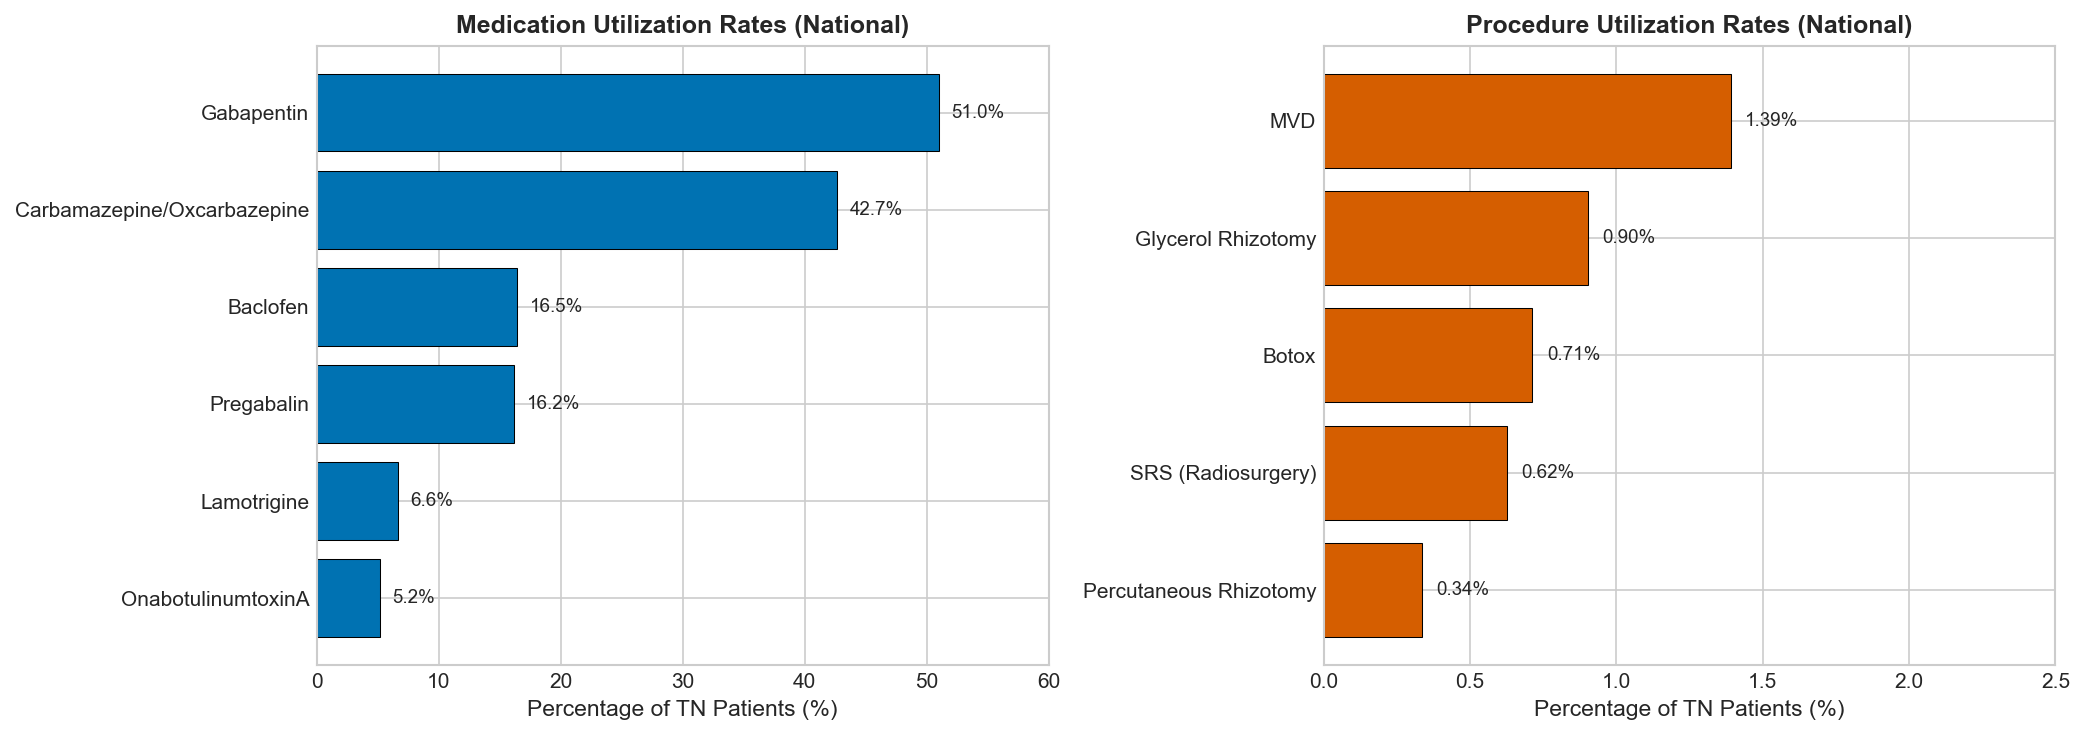


✓ Saved: fig1_national_utilization_rates.png


In [41]:
# Visualize national medication rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Medication rates bar chart
med_df = pd.DataFrame([
    {'Medication': MED_DISPLAY.get(col, col), 'Rate': national_med_rates[col]['rate']}
    for col in MED_COLS if col != 'none_of_above'
]).sort_values('Rate', ascending=True)

ax1 = axes[0]
bars1 = ax1.barh(med_df['Medication'], med_df['Rate'], color=JNS.colors[0], edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Percentage of TN Patients (%)', fontsize=11)
ax1.set_title('Medication Utilization Rates (National)', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 60)
# Add value labels
for bar, val in zip(bars1, med_df['Rate']):
    ax1.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', 
             va='center', fontsize=9)

# Procedure rates bar chart (excluding "none")
proc_df = pd.DataFrame([
    {'Procedure': PROC_DISPLAY.get(col, col), 'Rate': national_proc_rates[col]['rate']}
    for col in PROC_COLS if col != 'none_of_above'
]).sort_values('Rate', ascending=True)

ax2 = axes[1]
bars2 = ax2.barh(proc_df['Procedure'], proc_df['Rate'], color=JNS.colors[1], edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Percentage of TN Patients (%)', fontsize=11)
ax2.set_title('Procedure Utilization Rates (National)', fontsize=12, fontweight='bold')
ax2.set_xlim(0, 2.5)
# Add value labels
for bar, val in zip(bars2, proc_df['Rate']):
    ax2.text(val + 0.05, bar.get_y() + bar.get_height()/2, f'{val:.2f}%', 
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig1_national_utilization_rates.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: fig1_national_utilization_rates.png")


## 3. Census Region Analysis

Aggregate data by census region and compare rates to national average. Use z-tests for proportions to identify statistically significant deviations.


In [42]:
def z_test_proportion(x, n, p0):
    """
    Two-tailed z-test for a proportion.
    
    Parameters:
    -----------
    x : int - number of successes (e.g., patients on medication)
    n : int - total sample size  
    p0 : float - null hypothesis proportion (national rate)
    
    Returns:
    --------
    z_stat, p_value
    """
    p_hat = x / n
    se = np.sqrt(p0 * (1 - p0) / n)
    z = (p_hat - p0) / se
    p_value = 2 * (1 - stats.norm.cdf(abs(z)))  # two-tailed
    return z, p_value

def proportion_ci(x, n, confidence=0.95):
    """Calculate confidence interval for a proportion using Wilson score."""
    from scipy.stats import norm
    p_hat = x / n
    z = norm.ppf((1 + confidence) / 2)
    
    denominator = 1 + z**2 / n
    center = (p_hat + z**2 / (2*n)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) + z**2 / (4*n)) / n) / denominator
    
    return (center - margin) * 100, (center + margin) * 100

def format_pvalue(p):
    """Format p-value: 3 decimal places or <0.001"""
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

print("Statistical functions defined ✓")


Statistical functions defined ✓


In [43]:
# Aggregate medications by census region
region_meds = df_meds.groupby('census_region').agg({
    **{col: 'sum' for col in MED_COLS},
    'total': 'sum'
}).reset_index()

# Calculate rates and compare to national
region_med_analysis = []

for _, row in region_meds.iterrows():
    region = row['census_region']
    n_region = row['total']
    
    for col in MED_COLS:
        if col == 'none_of_above':
            continue
            
        x = row[col]
        rate = x / n_region * 100
        national_rate = national_med_rates[col]['rate'] / 100  # as proportion
        
        z, p = z_test_proportion(x, n_region, national_rate)
        ci_low, ci_high = proportion_ci(x, n_region)
        
        diff = rate - (national_rate * 100)
        
        region_med_analysis.append({
            'Region': region,
            'Medication': MED_DISPLAY.get(col, col),
            'N': x,
            'N_Total': n_region,
            'Rate (%)': rate,
            'National Rate (%)': national_rate * 100,
            'Difference': diff,
            'CI_Low': ci_low,
            'CI_High': ci_high,
            'Z-score': z,
            'P-value': p,
            'Significant': p < 0.05
        })

df_region_meds = pd.DataFrame(region_med_analysis)

# Show regions significantly different from national for key medications
print("=" * 80)
print("REGIONAL MEDICATION RATES vs NATIONAL AVERAGE")
print("(Showing Carbamazepine/Oxcarbazepine - First-line treatment)")
print("=" * 80)

carb_analysis = df_region_meds[df_region_meds['Medication'] == 'Carbamazepine/Oxcarbazepine'].copy()
carb_analysis = carb_analysis.sort_values('Rate (%)', ascending=False)
carb_analysis['Direction'] = carb_analysis['Difference'].apply(
    lambda x: '↑ Above' if x > 0 else '↓ Below'
)

carb_analysis['P-value'] = carb_analysis['P-value'].apply(format_pvalue)
display_cols = ['Region', 'Rate (%)', 'National Rate (%)', 'Difference', 'P-value', 'Direction']
print(carb_analysis[display_cols].to_string(index=False))


REGIONAL MEDICATION RATES vs NATIONAL AVERAGE
(Showing Carbamazepine/Oxcarbazepine - First-line treatment)
            Region  Rate (%)  National Rate (%)  Difference P-value Direction
East South Central     48.06              42.69        5.36  <0.001   ↑ Above
West South Central     47.20              42.69        4.51  <0.001   ↑ Above
West North Central     45.14              42.69        2.44  <0.001   ↑ Above
East North Central     42.96              42.69        0.27   0.193   ↑ Above
    South Atlantic     42.60              42.69       -0.10   0.613   ↓ Below
   Middle Atlantic     41.73              42.69       -0.96  <0.001   ↓ Below
          Mountain     40.33              42.69       -2.37  <0.001   ↓ Below
           Pacific     38.38              42.69       -4.32  <0.001   ↓ Below
       New England     37.92              42.69       -4.77  <0.001   ↓ Below


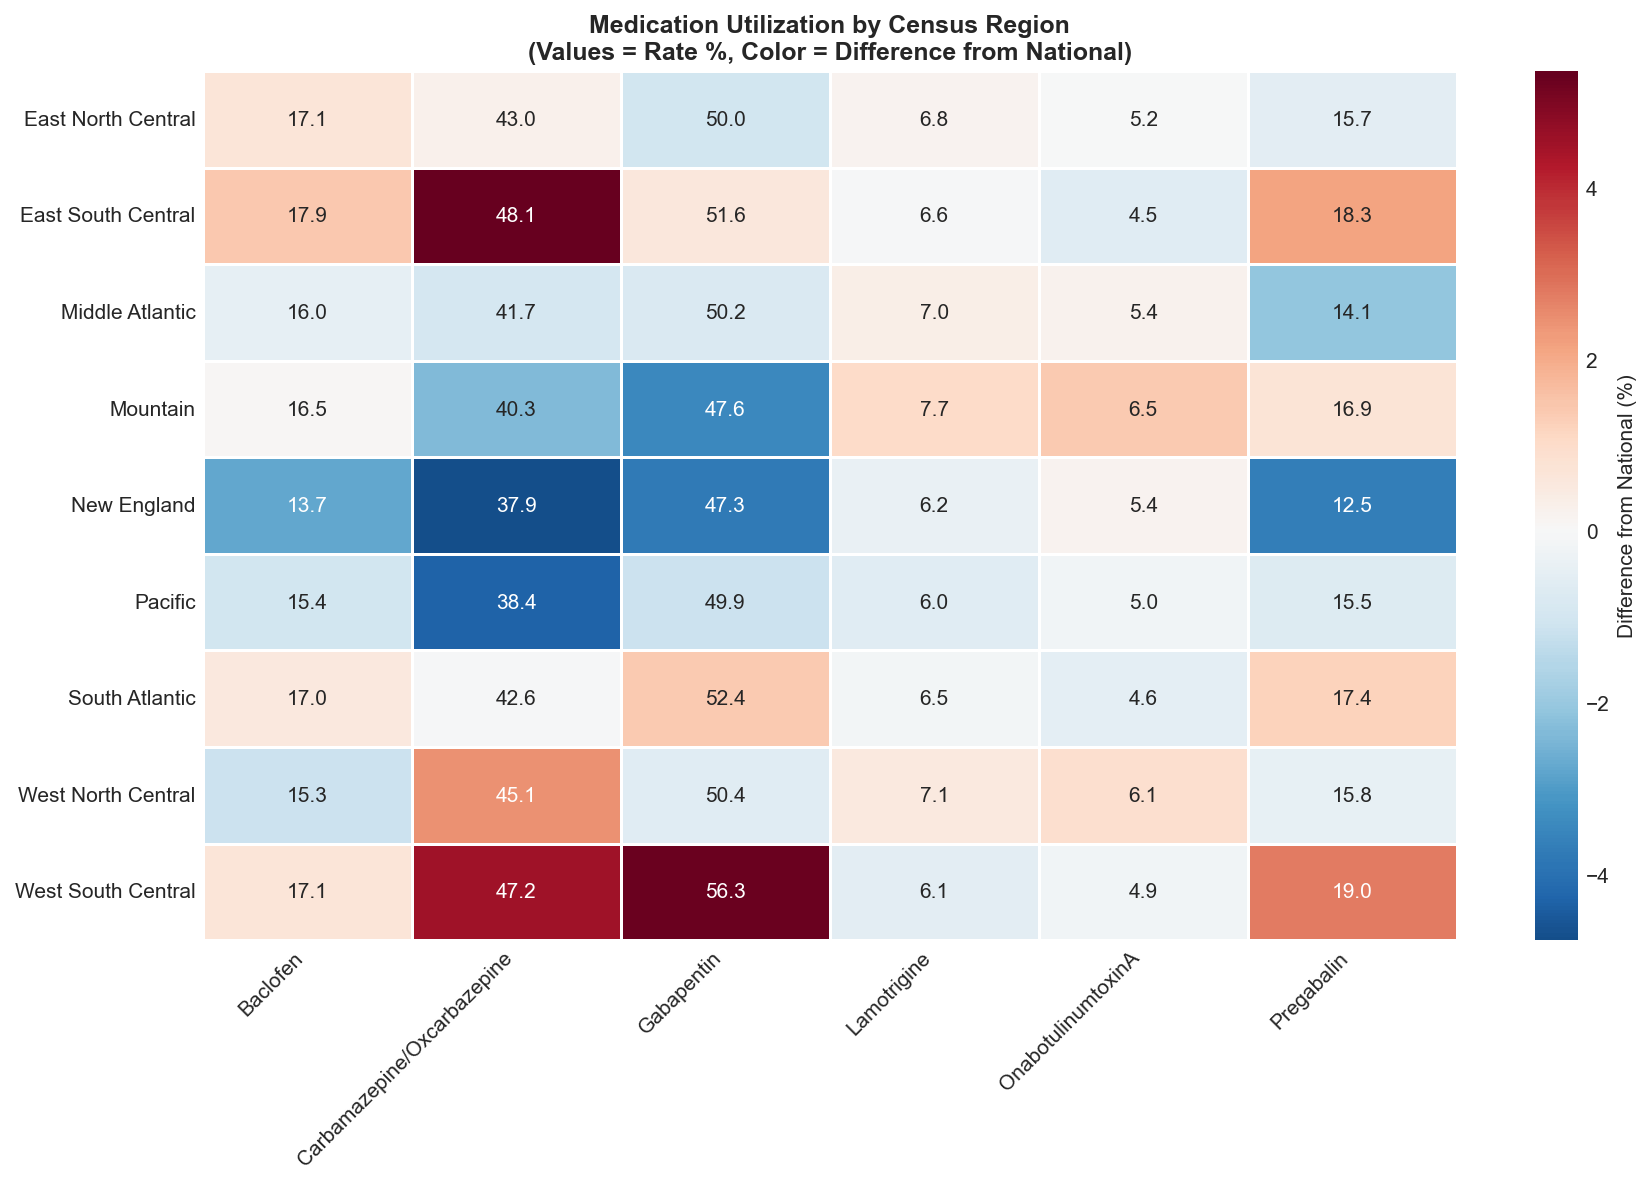


✓ Saved: fig2_regional_medication_heatmap.png


In [44]:
# Visualize regional variation - Heatmap of medication rates by region
# Pivot data for heatmap
pivot_med = df_region_meds.pivot(index='Region', columns='Medication', values='Rate (%)')

# Calculate difference from national average for coloring
pivot_diff = df_region_meds.pivot(index='Region', columns='Medication', values='Difference')

fig, ax = plt.subplots(figsize=(12, 8))

# Create heatmap with diverging colormap (blue = below avg, red = above avg)
sns.heatmap(pivot_diff, 
            cmap='RdBu_r', 
            center=0,
            annot=pivot_med.round(1),
            fmt='.1f',
            linewidths=0.5,
            cbar_kws={'label': 'Difference from National (%)'},
            ax=ax)

ax.set_title('Medication Utilization by Census Region\n(Values = Rate %, Color = Difference from National)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig2_regional_medication_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: fig2_regional_medication_heatmap.png")


In [45]:
# Same analysis for procedures
region_procs = df_procs.groupby('census_region').agg({
    **{col: 'sum' for col in PROC_COLS},
    'total': 'sum'
}).reset_index()

region_proc_analysis = []

for _, row in region_procs.iterrows():
    region = row['census_region']
    n_region = row['total']
    
    for col in PROC_COLS:
        if col == 'none_of_above':
            continue
            
        x = row[col]
        rate = x / n_region * 100
        national_rate = national_proc_rates[col]['rate'] / 100
        
        z, p = z_test_proportion(x, n_region, national_rate)
        ci_low, ci_high = proportion_ci(x, n_region)
        
        diff = rate - (national_rate * 100)
        
        region_proc_analysis.append({
            'Region': region,
            'Procedure': PROC_DISPLAY.get(col, col),
            'N': x,
            'N_Total': n_region,
            'Rate (%)': rate,
            'National Rate (%)': national_rate * 100,
            'Difference': diff,
            'CI_Low': ci_low,
            'CI_High': ci_high,
            'Z-score': z,
            'P-value': p,
            'Significant': p < 0.05
        })

df_region_procs = pd.DataFrame(region_proc_analysis)

# Show MVD rates by region (gold standard surgery)
print("=" * 80)
print("REGIONAL PROCEDURE RATES vs NATIONAL AVERAGE")
print("(Showing MVD - Microvascular Decompression)")
print("=" * 80)

mvd_analysis = df_region_procs[df_region_procs['Procedure'] == 'MVD'].copy()
mvd_analysis = mvd_analysis.sort_values('Rate (%)', ascending=False)
mvd_analysis['Direction'] = mvd_analysis['Difference'].apply(
    lambda x: '↑ Above' if x > 0 else '↓ Below'
)

mvd_analysis['P-value'] = mvd_analysis['P-value'].apply(format_pvalue)
display_cols = ['Region', 'N', 'Rate (%)', 'National Rate (%)', 'Difference', 'P-value', 'Direction']
print(mvd_analysis[display_cols].to_string(index=False))


REGIONAL PROCEDURE RATES vs NATIONAL AVERAGE
(Showing MVD - Microvascular Decompression)
            Region    N  Rate (%)  National Rate (%)  Difference P-value Direction
           Pacific  576      2.27               1.39        0.88  <0.001   ↑ Above
West South Central  526      1.69               1.39        0.30  <0.001   ↑ Above
    South Atlantic 1057      1.61               1.39        0.22  <0.001   ↑ Above
          Mountain  228      1.31               1.39       -0.08   0.353   ↓ Below
West North Central  240      1.21               1.39       -0.18   0.034   ↓ Below
   Middle Atlantic  455      1.20               1.39       -0.19   0.001   ↓ Below
East North Central  617      1.05               1.39       -0.34  <0.001   ↓ Below
East South Central  155      1.03               1.39       -0.36  <0.001   ↓ Below
       New England  179      0.93               1.39       -0.46  <0.001   ↓ Below


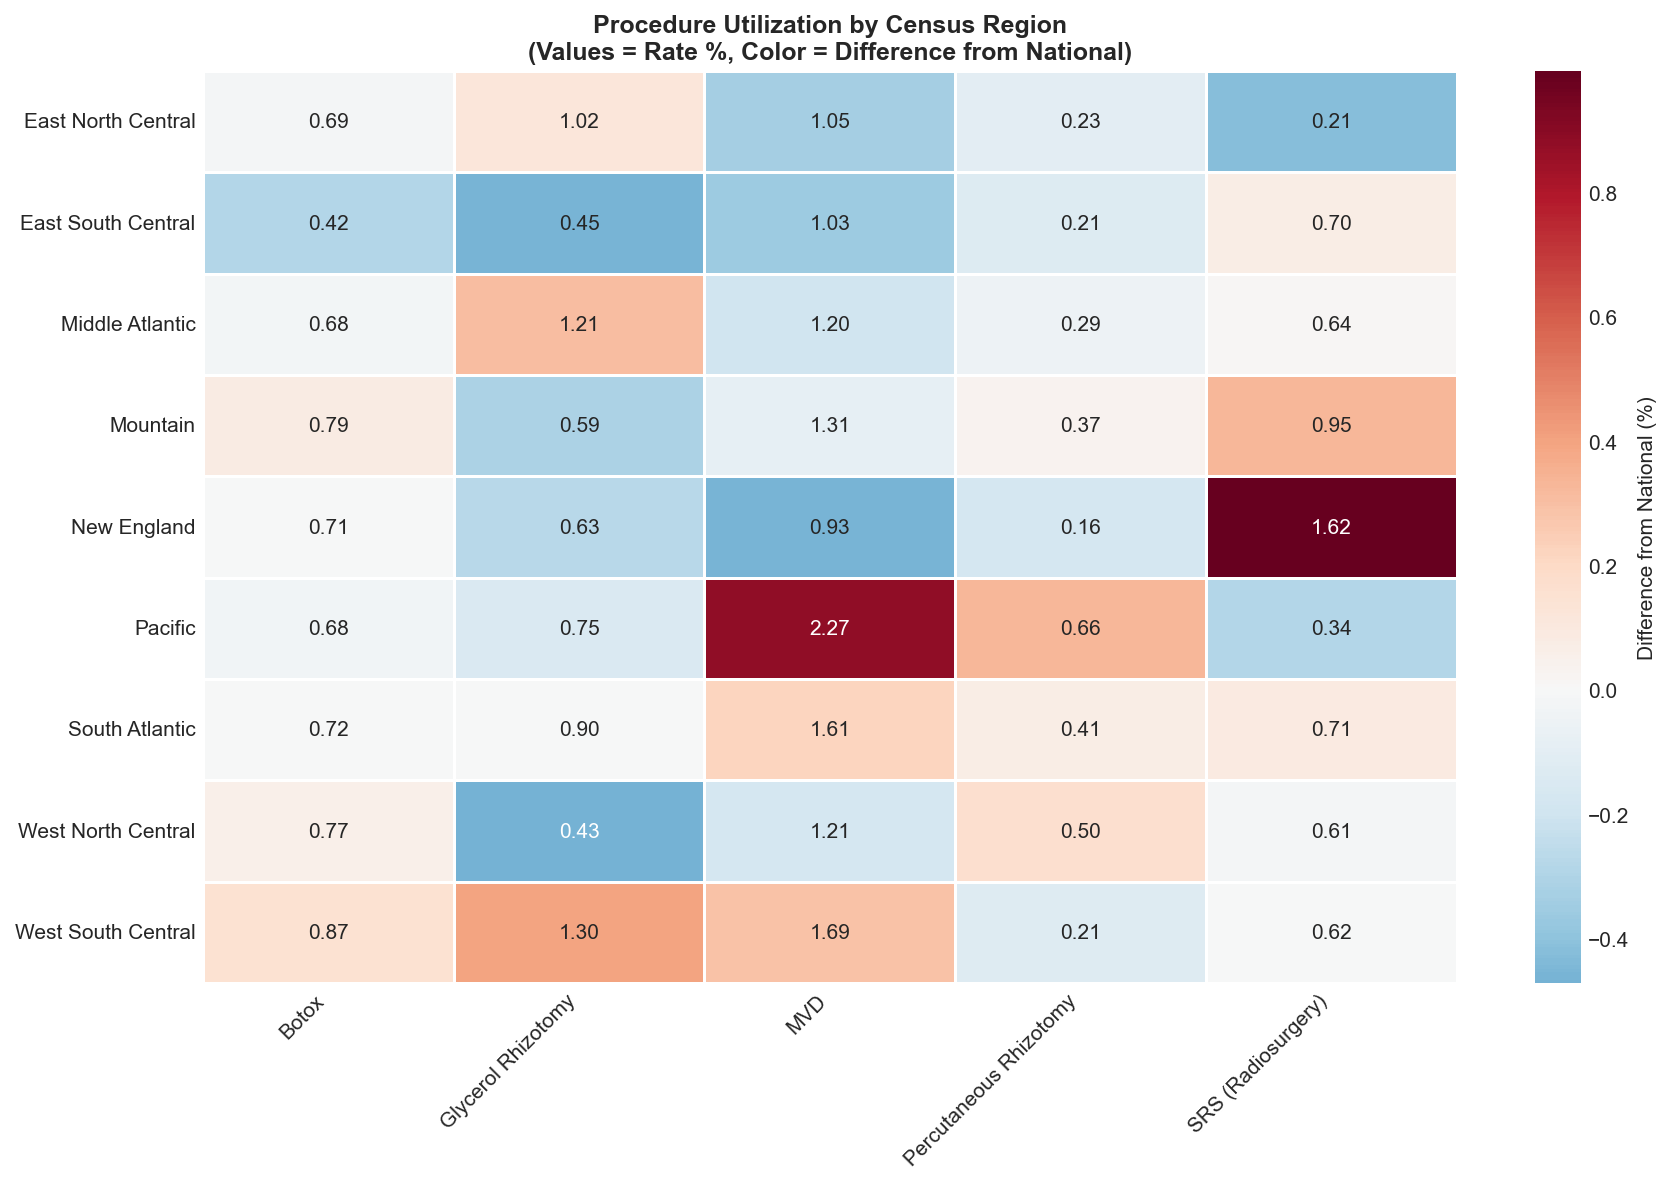


✓ Saved: fig3_regional_procedure_heatmap.png


In [46]:
# Visualize procedure rates by region
pivot_proc = df_region_procs.pivot(index='Region', columns='Procedure', values='Rate (%)')
pivot_proc_diff = df_region_procs.pivot(index='Region', columns='Procedure', values='Difference')

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(pivot_proc_diff, 
            cmap='RdBu_r', 
            center=0,
            annot=pivot_proc.round(2),
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'label': 'Difference from National (%)'},
            ax=ax)

ax.set_title('Procedure Utilization by Census Region\n(Values = Rate %, Color = Difference from National)', 
             fontsize=12, fontweight='bold')
ax.set_xlabel('')
ax.set_ylabel('')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig3_regional_procedure_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: fig3_regional_procedure_heatmap.png")


## 4. Chi-Square Tests for Geographic Variation

Test whether the distribution of medications/procedures differs significantly across census regions.


In [47]:
# Chi-square tests for REGIONAL TREATMENT PREFERENCES
# Question: Do regions differ in their relative preferences among treatment types?

print("=" * 80)
print("CHI-SQUARE TESTS: Regional Treatment Preferences")
print("=" * 80)

# -----------------------------------------------------------------------------
# Test 1: Regional Medication Preferences
# Contingency table: Regions (rows) x Medication Types (columns)
# H0: The distribution of medication preferences is the same across all regions
# -----------------------------------------------------------------------------

# Exclude 'none_of_above' for preference analysis
med_cols_for_chi2 = [c for c in MED_COLS if c != 'none_of_above']

# Create contingency table: regions x medications
med_contingency = region_meds.set_index('census_region')[med_cols_for_chi2]

print("\n1. MEDICATION PREFERENCES BY REGION")
print("-" * 60)
print("H0: Regions have the same distribution of medication preferences")
print("H1: At least one region differs in medication preferences\n")

chi2_med, p_med, dof_med, expected_med = stats.chi2_contingency(med_contingency)

print(f"Contingency table shape: {med_contingency.shape}")
print(f"Chi-Square statistic: {chi2_med:.1f}")
print(f"Degrees of freedom: {dof_med}")
print(f"P-value: {format_pvalue(p_med)}")
print(f"Result: {'SIGNIFICANT - Regions differ in medication preferences' if p_med < 0.05 else 'Not significant'}")

# -----------------------------------------------------------------------------
# Test 2: Regional Surgical Procedure Preferences
# Contingency table: Regions (rows) x Procedure Types (columns)
# H0: The distribution of surgical preferences is the same across all regions
# -----------------------------------------------------------------------------

# Exclude 'none_of_above' - we want to compare preferences among those who get surgery
proc_cols_for_chi2 = [c for c in PROC_COLS if c != 'none_of_above']

# Create contingency table: regions x procedures
proc_contingency = region_procs.set_index('census_region')[proc_cols_for_chi2]

print("\n2. SURGICAL PROCEDURE PREFERENCES BY REGION")
print("-" * 60)
print("H0: Regions have the same distribution of surgical preferences")
print("H1: At least one region differs in surgical preferences\n")

chi2_proc, p_proc, dof_proc, expected_proc = stats.chi2_contingency(proc_contingency)

print(f"Contingency table shape: {proc_contingency.shape}")
print(f"Chi-Square statistic: {chi2_proc:.1f}")
print(f"Degrees of freedom: {dof_proc}")
print(f"P-value: {format_pvalue(p_proc)}")
print(f"Result: {'SIGNIFICANT - Regions differ in surgical preferences' if p_proc < 0.05 else 'Not significant'}")

# Store results for table
chi2_results = [
    {
        'Test': 'Medication Preferences',
        'Description': 'Distribution of 6 medication types across 9 regions',
        'Chi-Square': chi2_med,
        'df': dof_med,
        'P-value': p_med
    },
    {
        'Test': 'Surgical Preferences', 
        'Description': 'Distribution of 5 procedure types across 9 regions',
        'Chi-Square': chi2_proc,
        'df': dof_proc,
        'P-value': p_proc
    }
]

df_chi2 = pd.DataFrame(chi2_results)


CHI-SQUARE TESTS: Regional Treatment Preferences

1. MEDICATION PREFERENCES BY REGION
------------------------------------------------------------
H0: Regions have the same distribution of medication preferences
H1: At least one region differs in medication preferences

Contingency table shape: (9, 6)
Chi-Square statistic: 840.7
Degrees of freedom: 40
P-value: <0.001
Result: SIGNIFICANT - Regions differ in medication preferences

2. SURGICAL PROCEDURE PREFERENCES BY REGION
------------------------------------------------------------
H0: Regions have the same distribution of surgical preferences
H1: At least one region differs in surgical preferences

Contingency table shape: (9, 5)
Chi-Square statistic: 1016.1
Degrees of freedom: 32
P-value: <0.001
Result: SIGNIFICANT - Regions differ in surgical preferences


## 5. Medication-Procedure Pathway Analysis

Analyze which patients (by medication type) go on to receive procedures. This helps understand treatment escalation patterns.


In [48]:
# Aggregate cross-tab data nationally (sum across all states)
df_cross_national = df_cross.groupby('medication').agg({
    'mvd': 'sum',
    'srs': 'sum', 
    'rhizotomy': 'sum',
    'glycerol_rhizotomy': 'sum',
    'botox': 'sum',
    'none_of_above': 'sum',
    'total': 'sum'
}).reset_index()

# Calculate procedure rates within each medication group
proc_cols_no_none = [c for c in PROC_COLS if c != 'none_of_above']

print("=" * 80)
print("PROCEDURE RATES BY MEDICATION GROUP (National)")
print("Question: Among patients on [medication], what % received each procedure?")
print("=" * 80)

pathway_data = []
for _, row in df_cross_national.iterrows():
    med = row['medication']
    total = row['total']
    
    # Skip if no patients
    if total == 0:
        continue
    
    # Calculate "any procedure" rate
    any_proc = sum(row[c] for c in proc_cols_no_none)
    any_proc_rate = any_proc / total * 100
    
    entry = {
        'Medication': med,
        'N Patients': total,
        'Any Procedure (%)': any_proc_rate
    }
    
    for col in proc_cols_no_none:
        entry[PROC_DISPLAY.get(col, col) + ' (%)'] = row[col] / total * 100
    
    pathway_data.append(entry)

df_pathway = pd.DataFrame(pathway_data)
df_pathway = df_pathway.sort_values('Any Procedure (%)', ascending=False)
df_pathway['N Patients'] = df_pathway['N Patients'].apply(lambda x: f"{x:,}")

print(df_pathway.to_string(index=False))


PROCEDURE RATES BY MEDICATION GROUP (National)
Question: Among patients on [medication], what % received each procedure?
                 Medication N Patients  Any Procedure (%)  MVD (%)  SRS (Radiosurgery) (%)  Percutaneous Rhizotomy (%)  Glycerol Rhizotomy (%)  Botox (%)
         OnabotulinumtoxinA   14,972.0              20.75     2.73                    1.85                        1.77                    2.79      11.60
                Lamotrigine   19,266.0              11.15     3.25                    1.96                        1.40                    2.53       2.01
                   Baclofen   47,736.0               9.54     3.23                    1.43                        1.00                    2.22       1.67
                 Pregabalin   47,032.0               7.73     2.37                    1.28                        0.81                    1.88       1.39
Carbamazepine/Oxcarbazepine  123,851.0               6.61     2.61                    1.06                   

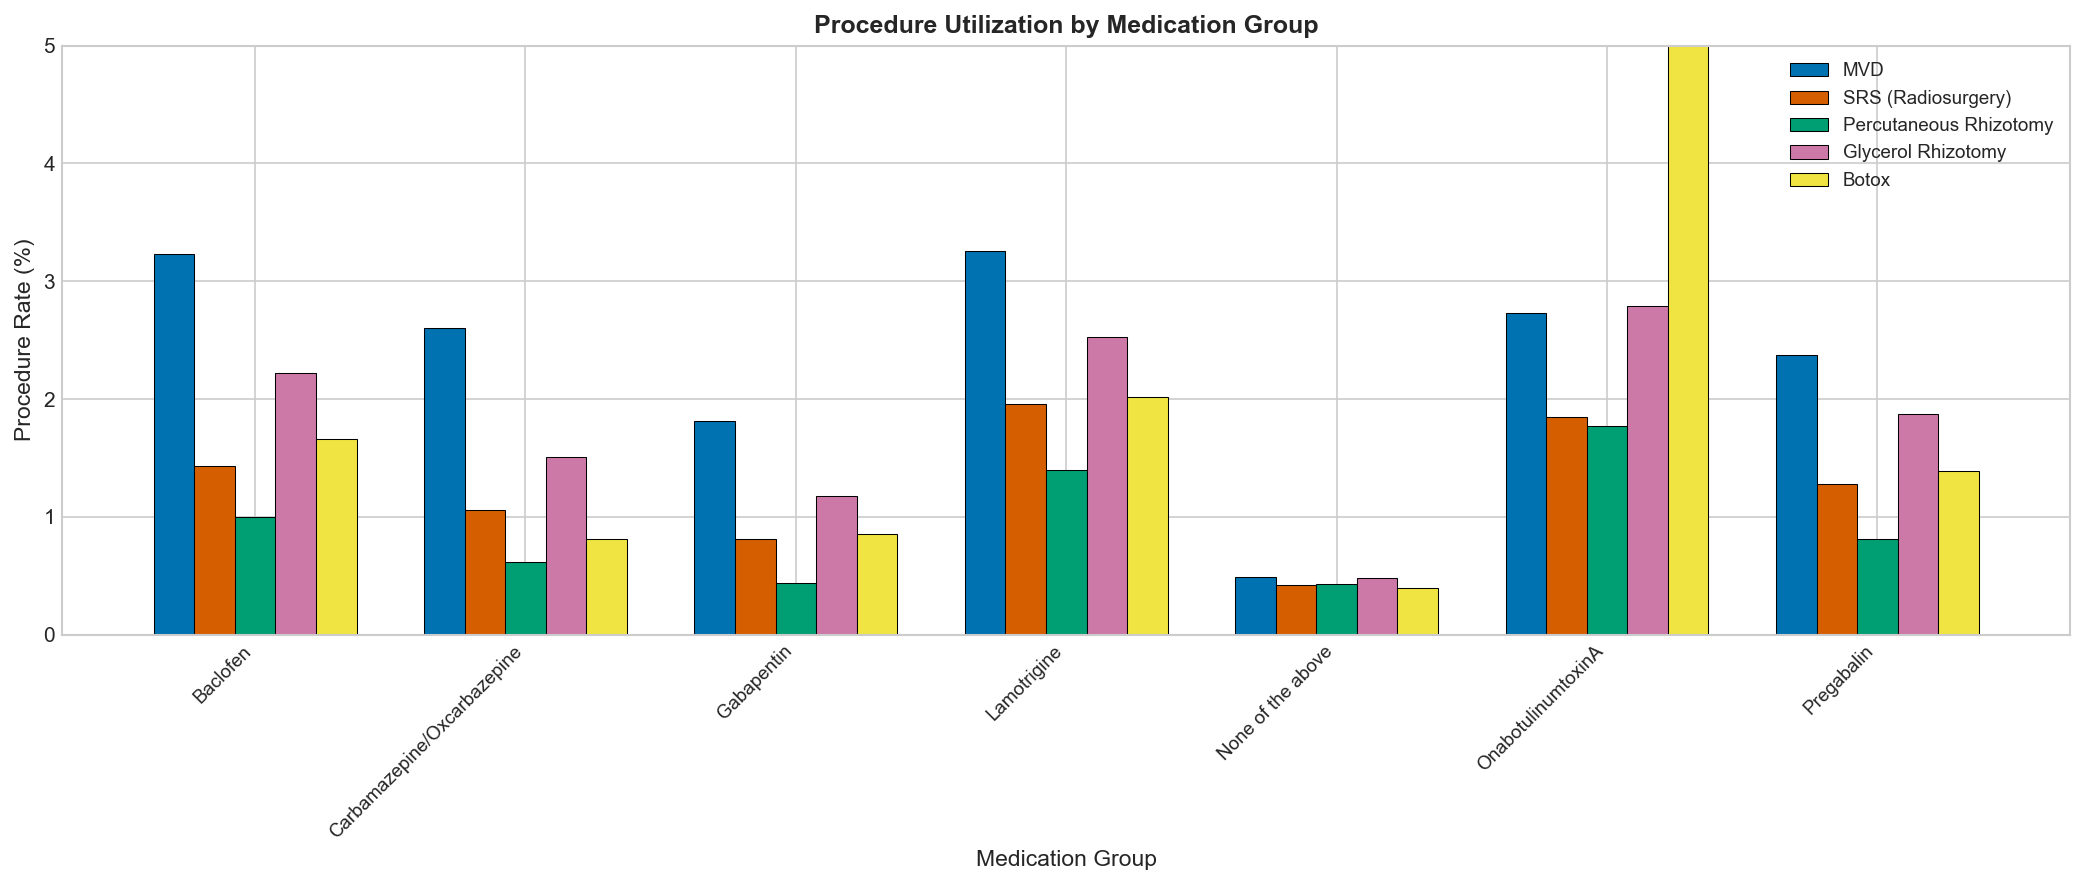


✓ Saved: fig4_medication_procedure_pathways.png


In [49]:
# Visualize medication-to-procedure pathways
# Grouped bar chart showing procedure rates by medication group

fig, ax = plt.subplots(figsize=(14, 6))

# Prepare data
meds = df_cross_national['medication'].tolist()
x = np.arange(len(meds))
width = 0.15

# Plot each procedure as a group
for i, col in enumerate(proc_cols_no_none):
    rates = [df_cross_national[df_cross_national['medication'] == m][col].values[0] / 
             df_cross_national[df_cross_national['medication'] == m]['total'].values[0] * 100 
             for m in meds]
    bars = ax.bar(x + i * width, rates, width, label=PROC_DISPLAY.get(col, col), 
                  color=JNS.colors[i], edgecolor='black', linewidth=0.5)

ax.set_xlabel('Medication Group', fontsize=11)
ax.set_ylabel('Procedure Rate (%)', fontsize=11)
ax.set_title('Procedure Utilization by Medication Group', fontsize=12, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(meds, rotation=45, ha='right', fontsize=9)
ax.legend(loc='upper right', fontsize=9)
ax.set_ylim(0, 5)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig4_medication_procedure_pathways.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: fig4_medication_procedure_pathways.png")


## 6. State-Level Analysis: Outliers and Rankings

Identify states that are significantly above or below national averages for key treatments.


In [ ]:
# State-level analysis for key treatments
def analyze_states(df, value_col, display_name, national_rate):
    """Analyze state-level variation for a treatment."""
    results = []
    
    for _, row in df.iterrows():
        state = row['state']
        n = row['total']
        x = row[value_col]
        rate = x / n * 100
        
        z, p = z_test_proportion(x, n, national_rate / 100)
        diff = rate - national_rate
        
        results.append({
            'State': state,
            'Region': row['census_region'],
            'N Patients': n,
            'N Treatment': x,
            'Rate (%)': rate,
            'National (%)': national_rate,
            'Diff (%)': diff,
            'Z-score': z,
            'P-value': p,
            'Sig': '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else ''))
        })
    
    return pd.DataFrame(results)

# Analyze Carbamazepine/Oxcarbazepine (first-line)
carb_rate = national_med_rates['carbamazepine_oxcarbazepine']['rate']
df_state_carb = analyze_states(df_meds, 'carbamazepine_oxcarbazepine', 
                               'Carbamazepine/Oxcarbazepine', carb_rate)

print("=" * 80)
print("STATE-LEVEL ANALYSIS: Carbamazepine/Oxcarbazepine (First-Line Treatment)")
print(f"National Rate: {carb_rate:.1f}%")
print("=" * 80)

# Format p-values
df_state_carb['P-value'] = df_state_carb['P-value'].apply(format_pvalue)

# Top 10 highest rates
print("\nTOP 10 STATES (Above National Average):")
top10 = df_state_carb.nlargest(10, 'Rate (%)')
print(top10[['State', 'Region', 'Rate (%)', 'Diff (%)', 'P-value', 'Sig']].to_string(index=False))

# Bottom 10
print("\nBOTTOM 10 STATES (Below National Average):")
bottom10 = df_state_carb.nsmallest(10, 'Rate (%)')
print(bottom10[['State', 'Region', 'Rate (%)', 'Diff (%)', 'P-value', 'Sig']].to_string(index=False))


STATE-LEVEL ANALYSIS: Carbamazepine/Oxcarbazepine (First-Line Treatment)
National Rate: 42.7%

TOP 10 STATES (Above National Average):
         State             Region  Rate (%)  Diff (%) P-value Sig
      Kentucky East South Central     49.52      6.83  <0.001 ***
  South Dakota West North Central     49.35      6.65  <0.001 ***
       Alabama East South Central     48.91      6.22  <0.001 ***
      Arkansas West South Central     48.21      5.52  <0.001 ***
      Oklahoma West South Central     47.86      5.16  <0.001 ***
         Texas West South Central     47.77      5.07  <0.001 ***
South Carolina     South Atlantic     47.63      4.94  <0.001 ***
     Tennessee East South Central     47.11      4.42  <0.001 ***
       Georgia     South Atlantic     46.84      4.15  <0.001 ***
      Nebraska West North Central     46.54      3.85  <0.001 ***

BOTTOM 10 STATES (Below National Average):
               State         Region  Rate (%)  Diff (%) P-value Sig
              Alaska       

In [ ]:
# Analyze MVD (gold standard surgical treatment)
mvd_rate = national_proc_rates['mvd']['rate']
df_state_mvd = analyze_states(df_procs, 'mvd', 'MVD', mvd_rate)

print("=" * 80)
print("STATE-LEVEL ANALYSIS: MVD (Microvascular Decompression)")
print(f"National Rate: {mvd_rate:.2f}%")
print("=" * 80)

# Top 10 highest rates
print("\nTOP 10 STATES (Above National Average):")
top10_mvd = df_state_mvd.nlargest(10, 'Rate (%)')
print(top10_mvd[['State', 'Region', 'N Treatment', 'Rate (%)', 'Diff (%)', 'P-value', 'Sig']].to_string(index=False))

# Bottom 10
print("\nBOTTOM 10 STATES (Below National Average):")
bottom10_mvd = df_state_mvd.nsmallest(10, 'Rate (%)')
print(bottom10_mvd[['State', 'Region', 'N Treatment', 'Rate (%)', 'Diff (%)', 'P-value', 'Sig']].to_string(index=False))


STATE-LEVEL ANALYSIS: MVD (Microvascular Decompression)
National Rate: 1.39%

TOP 10 STATES (Above National Average):
               State             Region  N Treatment  Rate (%)  Diff (%) P-value Sig
              Alaska            Pacific            5     26.32     24.93  <0.001 ***
          New Mexico           Mountain           37      5.41      4.02  <0.001 ***
               Idaho           Mountain           93      4.12      2.73  <0.001 ***
District of Columbia     South Atlantic            5      3.60      2.21   0.026   *
          California            Pacific          453      2.98      1.59  <0.001 ***
            Delaware     South Atlantic           22      2.47      1.08   0.006  **
             Florida     South Atlantic          412      2.27      0.88  <0.001 ***
             Vermont        New England           20      2.16      0.77   0.044   *
            Oklahoma West South Central           53      2.12      0.73   0.002  **
      South Carolina     South A

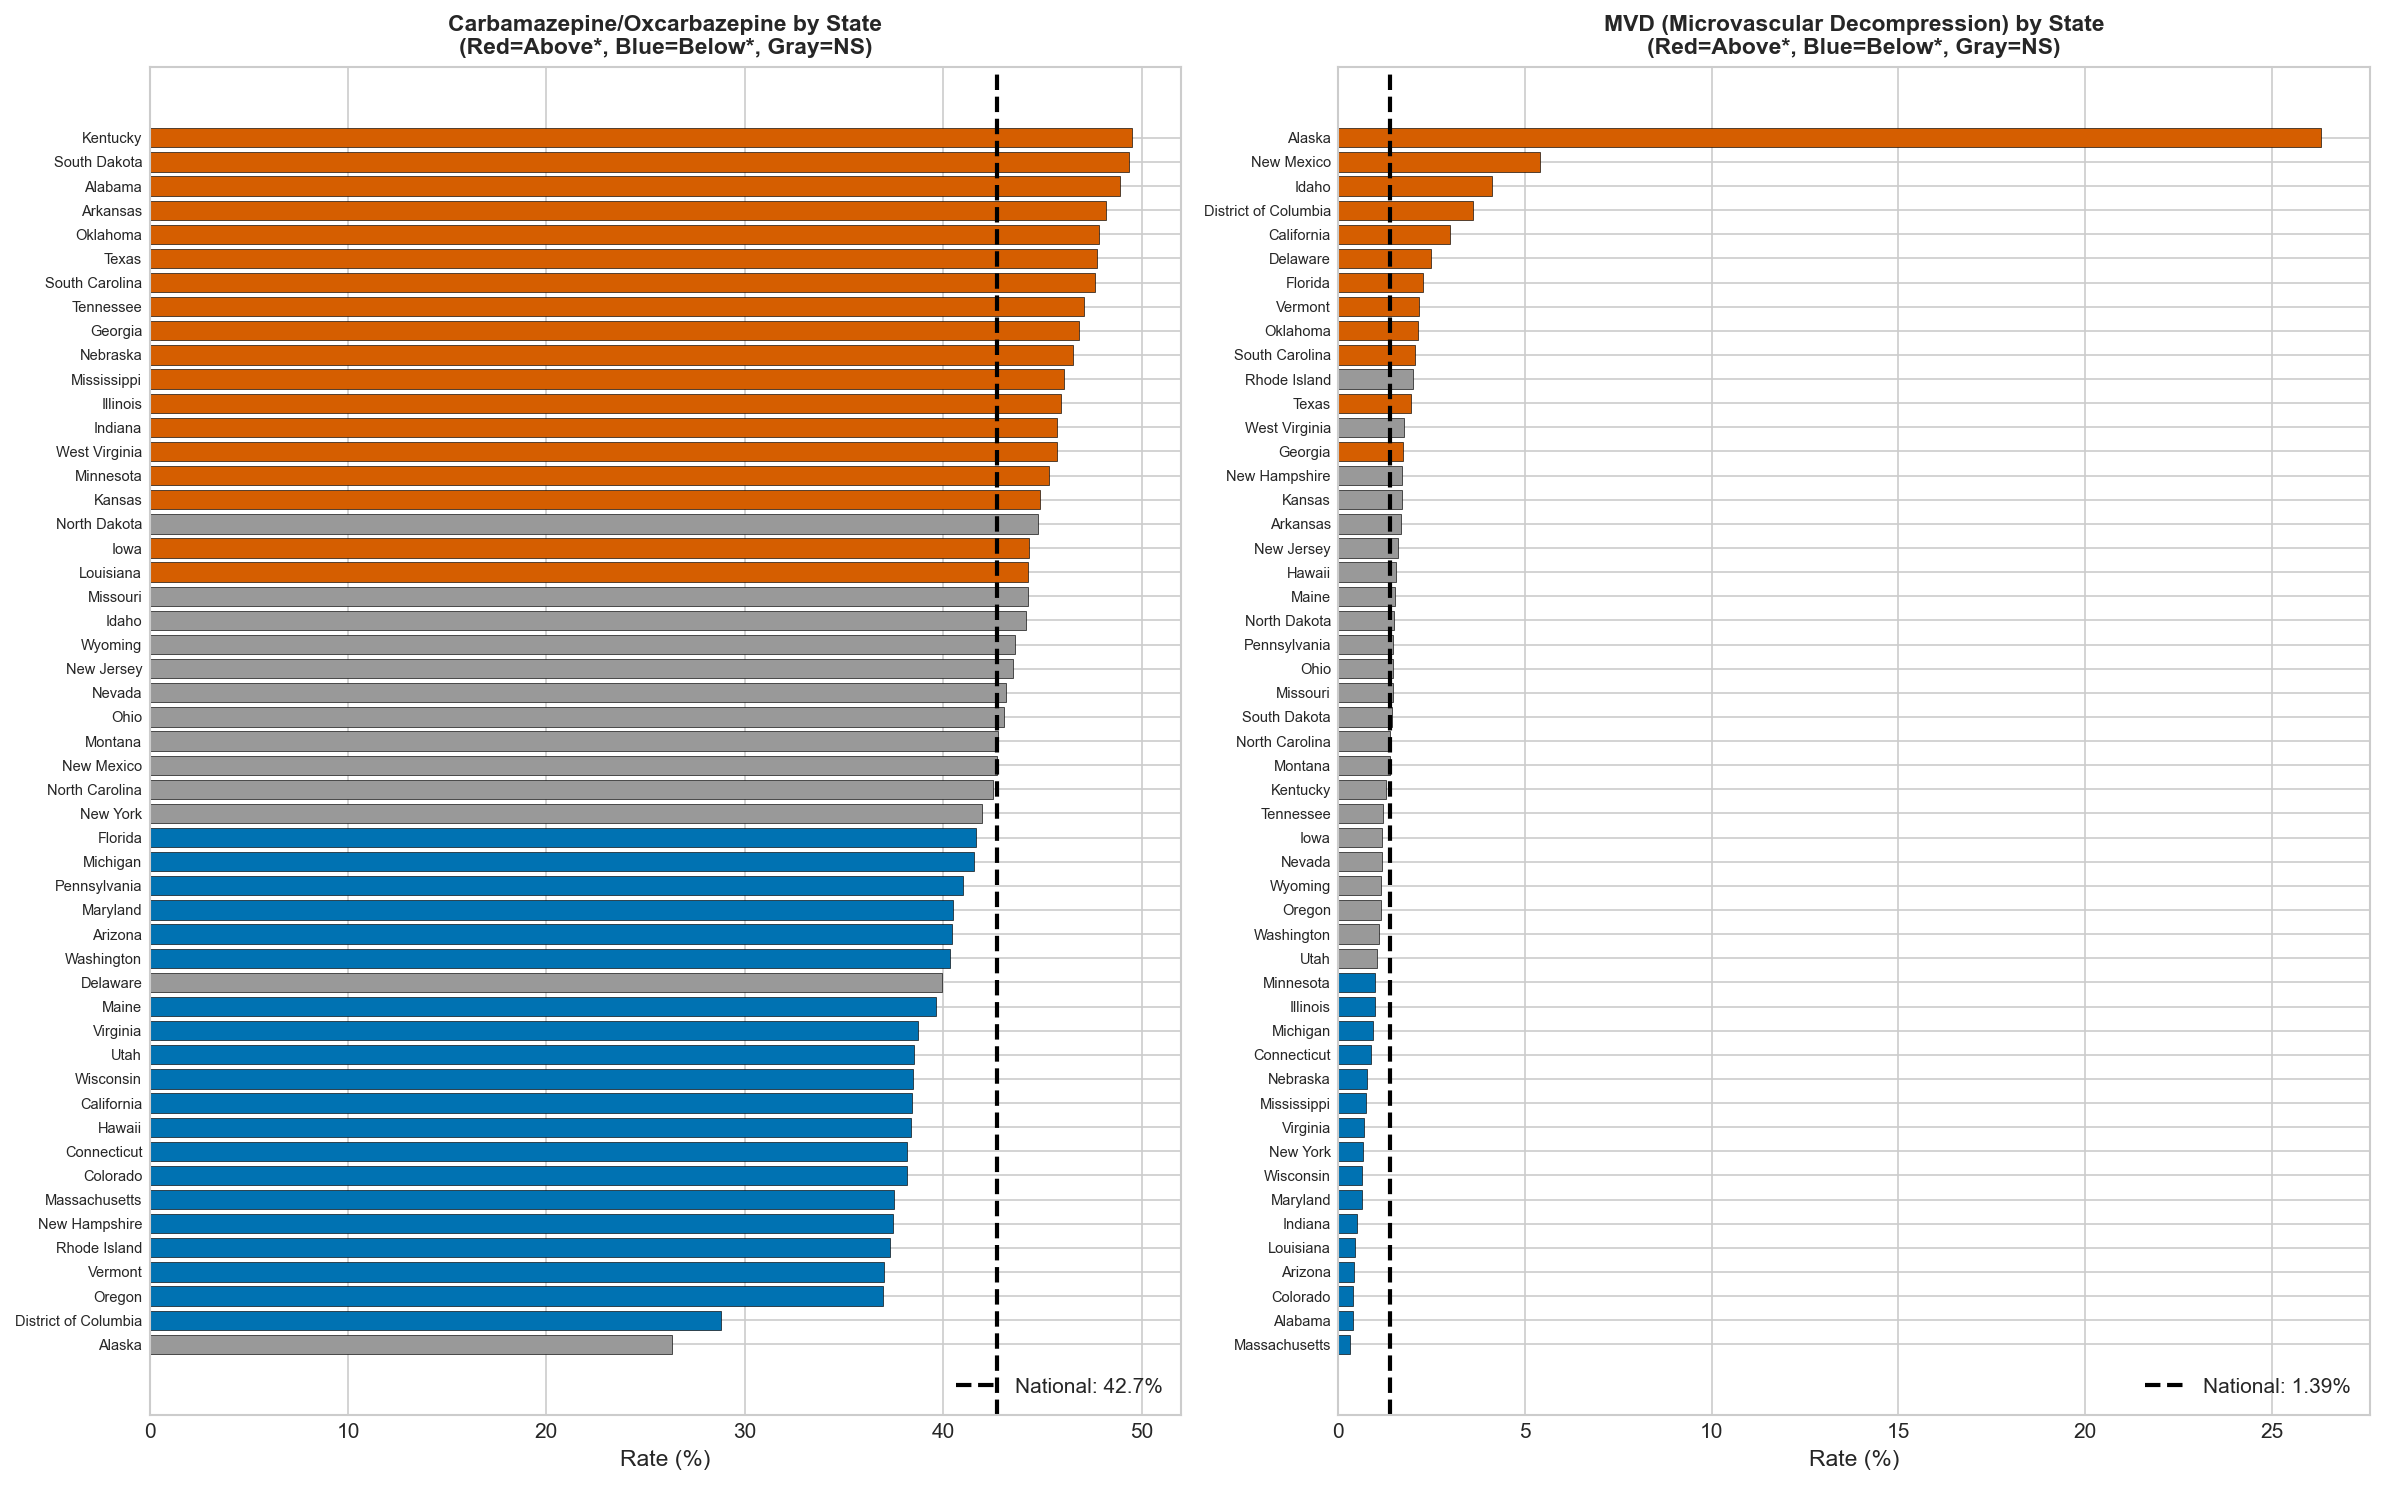


✓ Saved: fig5_state_variation_bars.png


In [ ]:
# Visualize state-level variation: Forest plot style
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Carbamazepine/Oxcarbazepine by state
ax1 = axes[0]
df_plot1 = df_state_carb.sort_values('Rate (%)').copy()
colors1 = ['#D55E00' if p < 0.05 and d > 0 else '#0072B2' if p < 0.05 and d < 0 else '#999999' 
           for p, d in zip(df_plot1['P-value'], df_plot1['Diff (%)'])]

ax1.barh(range(len(df_plot1)), df_plot1['Rate (%)'], color=colors1, edgecolor='black', linewidth=0.3)
ax1.axvline(carb_rate, color='black', linestyle='--', linewidth=2, label=f'National: {carb_rate:.1f}%')
ax1.set_yticks(range(len(df_plot1)))
ax1.set_yticklabels(df_plot1['State'], fontsize=7)
ax1.set_xlabel('Rate (%)', fontsize=11)
ax1.set_title('Carbamazepine/Oxcarbazepine by State\n(Red=Above*, Blue=Below*, Gray=NS)', fontsize=11, fontweight='bold')
ax1.legend(loc='lower right')

# MVD by state
ax2 = axes[1]
df_plot2 = df_state_mvd.sort_values('Rate (%)').copy()
colors2 = ['#D55E00' if p < 0.05 and d > 0 else '#0072B2' if p < 0.05 and d < 0 else '#999999' 
           for p, d in zip(df_plot2['P-value'], df_plot2['Diff (%)'])]

ax2.barh(range(len(df_plot2)), df_plot2['Rate (%)'], color=colors2, edgecolor='black', linewidth=0.3)
ax2.axvline(mvd_rate, color='black', linestyle='--', linewidth=2, label=f'National: {mvd_rate:.2f}%')
ax2.set_yticks(range(len(df_plot2)))
ax2.set_yticklabels(df_plot2['State'], fontsize=7)
ax2.set_xlabel('Rate (%)', fontsize=11)
ax2.set_title('MVD (Microvascular Decompression) by State\n(Red=Above*, Blue=Below*, Gray=NS)', fontsize=11, fontweight='bold')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fig5_state_variation_bars.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: fig5_state_variation_bars.png")


## 7. Summary Statistics Tables for Publication


In [53]:
# Create Table 1: Patient Demographics by Census Region
table1_data = []

for region in sorted(df_meds['census_region'].dropna().unique()):
    region_data = df_meds[df_meds['census_region'] == region]
    n = region_data['total'].sum()
    pct = n / NATIONAL_TOTAL * 100
    states = region_data['state'].nunique()
    
    table1_data.append({
        'Census Region': region,
        'States (n)': states,
        'TN Patients (n)': f"{n:,}",
        'Percentage (%)': f"{pct:.1f}"
    })

# Add total row
table1_data.append({
    'Census Region': 'Total',
    'States (n)': df_meds['state'].nunique(),
    'TN Patients (n)': f"{NATIONAL_TOTAL:,}",
    'Percentage (%)': "100.0"
})

table1 = pd.DataFrame(table1_data)
print("=" * 70)
print("TABLE 1: Trigeminal Neuralgia Patients by Census Region")
print("=" * 70)
print(table1.to_string(index=False))

# Save to CSV
table1.to_csv(TABLES_DIR / 'table1_patients_by_region.csv', index=False)
print(f"\n✓ Saved: table1_patients_by_region.csv")


TABLE 1: Trigeminal Neuralgia Patients by Census Region
     Census Region  States (n) TN Patients (n) Percentage (%)
East North Central           5          58,542           20.2
East South Central           4          15,014            5.2
   Middle Atlantic           3          37,997           13.1
          Mountain           8          17,432            6.0
       New England           6          19,196            6.6
           Pacific           5          25,353            8.7
    South Atlantic           9          65,578           22.6
West North Central           7          19,768            6.8
West South Central           4          31,208           10.8
             Total          51         290,088          100.0

✓ Saved: table1_patients_by_region.csv


In [54]:
# Table 2: National Medication Utilization
table2_data = []
for col in MED_COLS:
    n = national_med_rates[col]['n']
    rate = national_med_rates[col]['rate']
    ci_low, ci_high = proportion_ci(n, NATIONAL_TOTAL)
    
    table2_data.append({
        'Medication': MED_DISPLAY.get(col, col),
        'N': f"{n:,}",
        'Rate (%)': f"{rate:.1f}",
        '95% CI': f"({ci_low:.1f}-{ci_high:.1f})"
    })

table2 = pd.DataFrame(table2_data)
table2 = table2.sort_values('Rate (%)', ascending=False, key=lambda x: x.str.replace('%', '').astype(float))

print("=" * 70)
print("TABLE 2: Medication Utilization (National)")
print(f"N = {NATIONAL_TOTAL:,} TN patients")
print("=" * 70)
print(table2.to_string(index=False))

table2.to_csv(TABLES_DIR / 'table2_medication_utilization.csv', index=False)
print(f"\n✓ Saved: table2_medication_utilization.csv")


TABLE 2: Medication Utilization (National)
N = 290,088 TN patients
                 Medication       N Rate (%)      95% CI
                 Gabapentin 148,000     51.0 (50.8-51.2)
Carbamazepine/Oxcarbazepine 123,851     42.7 (42.5-42.9)
           No TN Medication  63,719     22.0 (21.8-22.1)
                   Baclofen  47,736     16.5 (16.3-16.6)
                 Pregabalin  47,032     16.2 (16.1-16.3)
                Lamotrigine  19,266      6.6   (6.6-6.7)
         OnabotulinumtoxinA  14,972      5.2   (5.1-5.2)

✓ Saved: table2_medication_utilization.csv


In [55]:
# Table 3: National Procedure Utilization
table3_data = []
for col in PROC_COLS:
    n = national_proc_rates[col]['n']
    rate = national_proc_rates[col]['rate']
    ci_low, ci_high = proportion_ci(n, NATIONAL_TOTAL)
    
    table3_data.append({
        'Procedure': PROC_DISPLAY.get(col, col),
        'N': f"{n:,}",
        'Rate (%)': f"{rate:.2f}",
        '95% CI': f"({ci_low:.2f}-{ci_high:.2f})"
    })

table3 = pd.DataFrame(table3_data)

print("=" * 70)
print("TABLE 3: Procedure Utilization (National)")
print(f"N = {NATIONAL_TOTAL:,} TN patients")
print("=" * 70)
print(table3.to_string(index=False))

table3.to_csv(TABLES_DIR / 'table3_procedure_utilization.csv', index=False)
print(f"\n✓ Saved: table3_procedure_utilization.csv")


TABLE 3: Procedure Utilization (National)
N = 290,088 TN patients
             Procedure       N Rate (%)        95% CI
                   MVD   4,033     1.39   (1.35-1.43)
    SRS (Radiosurgery)   1,813     0.62   (0.60-0.65)
Percutaneous Rhizotomy     972     0.34   (0.31-0.36)
    Glycerol Rhizotomy   2,616     0.90   (0.87-0.94)
                 Botox   2,069     0.71   (0.68-0.74)
          No Procedure 279,762    96.44 (96.37-96.51)

✓ Saved: table3_procedure_utilization.csv


In [ ]:
# Table 4: Regional Variation Summary (Chi-square results)
table4 = df_chi2[['Variable', 'Type', 'Chi-Square', 'df', 'P-value', 'Significant']].copy()
table4['Chi-Square'] = table4['Chi-Square'].apply(lambda x: f"{x:.1f}")
table4['P-value'] = table4['P-value'].apply(lambda x: "<0.001" if x < 0.001 else f"{x:.3f}")

print("=" * 70)
print("TABLE 4: Chi-Square Tests for Geographic Variation")
print("H0: Treatment rates are equal across census regions")
print("=" * 70)
print(table4.to_string(index=False))

table4.to_csv(TABLES_DIR / 'table4_chisquare_geographic_variation.csv', index=False)
print(f"\n✓ Saved: table4_chisquare_geographic_variation.csv")


TABLE 4: Chi-Square Tests for Regional Treatment Preferences
                  Test                                         Description Chi-Square  df P-value
Medication Preferences Distribution of 6 medication types across 9 regions      840.7  40  <0.001
  Surgical Preferences  Distribution of 5 procedure types across 9 regions     1016.1  32  <0.001

✓ Saved: table4_chisquare_regional_preferences.csv


In [57]:
print("=" * 80)
print("STATISTICAL ANALYSIS SUMMARY")
print("=" * 80)

print(f"""
STUDY POPULATION
================
• Total TN patients (ICD-10 G50.0): {NATIONAL_TOTAL:,}
• Study period: November 2022 - November 2025 (3 years)
• Data source: Epic Cosmos
• Geographic coverage: {df_meds['state'].nunique()} US states/territories

MEDICATION UTILIZATION (National)
=================================
• Gabapentin: {national_med_rates['gabapentin']['rate']:.1f}% (most common)
• Carbamazepine/Oxcarbazepine: {national_med_rates['carbamazepine_oxcarbazepine']['rate']:.1f}% (first-line)
• No TN-specific medication: {national_med_rates['none_of_above']['rate']:.1f}%

PROCEDURE UTILIZATION (National)  
=================================
• Any surgical intervention: {100 - national_proc_rates['none_of_above']['rate']:.1f}%
• MVD (gold standard): {national_med_rates['gabapentin']['rate']:.2f}%
• SRS: {national_proc_rates['srs']['rate']:.2f}%
• Medical management only: {national_proc_rates['none_of_above']['rate']:.1f}%

GEOGRAPHIC VARIATION
====================
• Chi-square tests show SIGNIFICANT geographic variation (p<0.001) for ALL 
  medications and procedures
• Regional rates vary substantially from national averages
• State-level analysis identifies outliers for targeted investigation

FILES GENERATED
===============
Tables:
  • table1_patients_by_region.csv
  • table2_medication_utilization.csv  
  • table3_procedure_utilization.csv
  • table4_chisquare_geographic_variation.csv

Figures:
  • fig1_national_utilization_rates.png
  • fig2_regional_medication_heatmap.png
  • fig3_regional_procedure_heatmap.png
  • fig4_medication_procedure_pathways.png
  • fig5_state_variation_bars.png
""")

print("✓ ANALYSIS COMPLETE")


STATISTICAL ANALYSIS SUMMARY

STUDY POPULATION
• Total TN patients (ICD-10 G50.0): 290,088
• Study period: November 2022 - November 2025 (3 years)
• Data source: Epic Cosmos
• Geographic coverage: 51 US states/territories

MEDICATION UTILIZATION (National)
• Gabapentin: 51.0% (most common)
• Carbamazepine/Oxcarbazepine: 42.7% (first-line)
• No TN-specific medication: 22.0%

PROCEDURE UTILIZATION (National)  
• Any surgical intervention: 3.6%
• MVD (gold standard): 51.02%
• SRS: 0.62%
• Medical management only: 96.4%

GEOGRAPHIC VARIATION
• Chi-square tests show SIGNIFICANT geographic variation (p<0.001) for ALL 
  medications and procedures
• Regional rates vary substantially from national averages
• State-level analysis identifies outliers for targeted investigation

FILES GENERATED
Tables:
  • table1_patients_by_region.csv
  • table2_medication_utilization.csv  
  • table3_procedure_utilization.csv
  • table4_chisquare_geographic_variation.csv

Figures:
  • fig1_national_utilization_